# **ECG Heartbeat Classification**

## **1. Table of Content**

- [1. Intro]()
- [2. Introduction to ECG Signals]()
  - [Why Classify ECG Signals?]()

### **1. Intro**

Welcome to the **Cardio AI** project! This Jupyter Notebook is your entry point into understanding **ECG Heartbeat Classification** from the ground up. We'll explore time series data, ECG signals, and various methods to classify heartbeats, ultimately helping to determine the best approach for the [**Kaggle ECG Heartbeat Categorization Dataset**](https://www.kaggle.com/datasets/shayanfazeli/heartbeat).

#### **🔍 Why Classify ECG Signals?**

Accurately classifying ECG signals helps in diagnosing heart conditions. For example:

- **Normal Beats (N)**
    
- **Arrhythmias**: Supraventricular Ectopic Beats (S), Ventricular Ectopic Beats (V), Fusion Beats (F), and Unknown Beats (Q).

## **2. Import the necessary libraries and load the dataset.**

In [2]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import zscore
from collections import Counter
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
# from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, BatchNormalization, Flatten, MaxPool1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import label_binarize
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the training and testing datasets
train_df = pd.read_csv('E:\Final Project\Heartbeeat\mitbih_train.csv', header=None)
test_df = pd.read_csv('E:\Final Project\Heartbeeat\mitbih_test.csv', header=None)

# Rename columns: 1 to 187 for ECG data, Label for the label
train_df.columns = [i+1 for i in range(187)] + ['Label']
test_df.columns = [i+1 for i in range(187)] + ['Label']

# Display the first few rows of the training dataset
train_df.head()

,1,2,3,4,5,6,7,8,9,10,...,179,180,181,182,183,184,185,186,187,Label
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **📝 Dataset Structure**
- **Rows:** Each row represents an individual heartbeat segment.

- **Columns:**

    - The first **187 columns** are the time-series values of the ECG signal.
    
    - The **188th column** is the label (heartbeat class).
 
### **📋 Summary of Classes**
| Class Label | Class Description | Code |
| :---------- | :---------------- | :--- |
| **0** | Normal Beat | **N** |
| **1** | Supraventricular Ectopic Beat | **S** |
| **2** | Ventricular Ectopic Beat | **V** |
| **3** | Fusion Beat | **F** |
| **4** | Unknown Beat | **Q** |

## **3. Initial Data Inspection**

### **3.1 Check Dataset Size**

In [4]:
print(f"Training Set Shape: {train_df.shape}")
print(f"Testing Set Shape: {test_df.shape}")

Training Set Shape: (87554, 188)
Testing Set Shape: (21892, 188)


### **3.2 Check for Missing Values**

In [5]:
print(f"Missing values in train_df: {train_df.isnull().sum().sum()}")
print(f"Missing values in test_df: {test_df.isnull().sum().sum()}")

Missing values in train_df: 0
Missing values in test_df: 0


**Interpretation:** The dataset has no missing values.

### **3.3 Class Distribution in Training and Testing Sets**

In [6]:
train_labels = train_df.iloc[:, -1]
test_labels = test_df.iloc[:, -1]

# Count the occurrences of each class
train_class_counts = Counter(train_labels)
test_class_counts = Counter(test_labels)

print(f"Training Set Class Distribution: {train_class_counts}")
print(f"Testing Set Class Distribution: {test_class_counts}")

Training Set Class Distribution: Counter({0.0: 72471, 4.0: 6431, 2.0: 5788, 1.0: 2223, 3.0: 641})
Testing Set Class Distribution: Counter({0.0: 18118, 4.0: 1608, 2.0: 1448, 1.0: 556, 3.0: 162})


### **📝 Observations**
- Notice the **imbalance** in class distribution. Some classes have far fewer samples than others.

- This imbalance may affect model performance, requiring techniques like **resampling** or **class weighting**.

## **4. Visualizing ECG Signals**

### **4.1 Plot Example Heartbeats for Each Class**

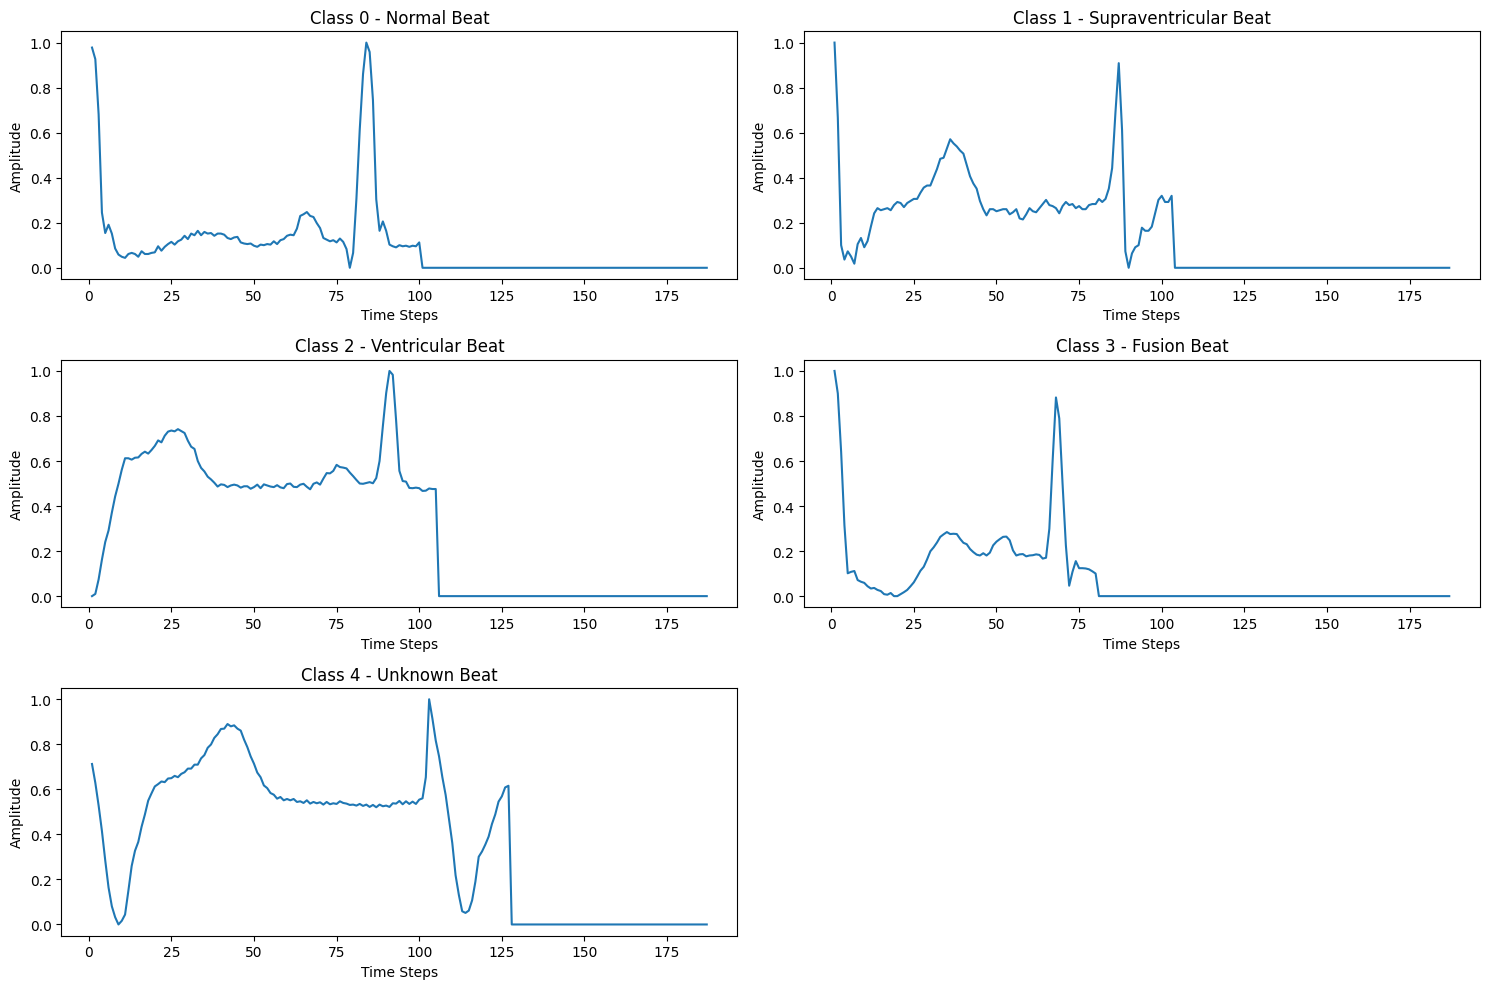

In [7]:
plt.figure(figsize=(15, 10))

# Plot one example from each class
for label in range(5):
    plt.subplot(3, 2, label + 1)
    sample = train_df[train_df.iloc[:, -1] == label].iloc[0, :-1]
    plt.plot(sample)
    plt.title(f"Class {label} - {['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown'][label]} Beat")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

### **4.2 Dynamic ECG Visualization with Bokeh**

In [8]:
# Select one sample for each class
class_labels = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown']
samples = [train_df[train_df.iloc[:, -1] == i].iloc[0, :-1].values for i in range(5)]

# Output to Jupyter Notebook
output_notebook()

# Create a Bokeh figure
p = figure(
    title="Interactive ECG Signals for Each Class",
    x_axis_label='Time Steps',
    y_axis_label='Amplitude',
    width=900,
    height=500,
    tools="pan,wheel_zoom,box_zoom,reset,save"
)

# Add hover tool
hover = HoverTool(tooltips=[("Time Step", "$index"), ("Amplitude", "@y")])
p.add_tools(hover)

# Add lines for each class
colors = ['blue', 'green', 'red', 'orange', 'purple']
time_steps = np.arange(len(samples[0]))  # Convert range to numpy array for x-axis

for i, sample in enumerate(samples):
    p.line(time_steps, sample, legend_label=f'Class {i} - {class_labels[i]}', color=colors[i], line_width=2)

# Customize the legend
p.legend.title = "ECG Classes"
p.legend.location = "top_right"

# Show the plot
show(p)

Loading BokehJS ...

### **📝 Observations**
- **Normal Beats (Class 0)** typically have a regular, consistent pattern.

- **Supraventricular Ectopic Beats (Class 1)** may show variations in the P-wave (abnormal P-waves).

- **Ventricular Ectopic Beats (Class 2)** often have a wider QRS complex.

- **Fusion Beats (Class 3)** show a mix of normal and abnormal features.

- **Unknown Beats (Class 4)** exhibit irregular patterns.

## **5. Statistical Analysis of Features**

### **5.1 Descriptive Statistics**
Get basic statistics (mean, standard deviation, etc.) for the signal values.

In [9]:
train_stats = train_df.describe()
print(train_stats)

                  1             2             3             4             5  \
count  87554.000000  87554.000000  87554.000000  87554.000000  87554.000000   
mean       0.890360      0.758160      0.423972      0.219104      0.201127   
std        0.240909      0.221813      0.227305      0.206878      0.177058   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.921922      0.682486      0.250969      0.048458      0.082329   
50%        0.991342      0.826013      0.429472      0.166000      0.147878   
75%        1.000000      0.910506      0.578767      0.341727      0.258993   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                  6             7             8             9            10  \
count  87554.000000  87554.000000  87554.000000  87554.000000  87554.000000   
mean       0.210399      0.205808      0.201773      0.198691      0.196757   
std        0.171909      0.178481      0.177240    

### **📝 Interpreting the Output for ECG Data**
Let's go through the interpretation of these statistics in the context of **ECG signals**:

1. **Count:**
    - All columns have `87554` entries, meaning **no missing data** in the training set.

2. **Mean:**
    - The average values for each time step are relatively small (e.g., `0.118`, `0.235`), reflecting the typical range of ECG signal amplitudes.

3. **Standard Deviation (std):**
    - Small standard deviations (e.g., `0.154`, `0.128`) suggest that the ECG signal values are **consistent** and do not vary wildly.

4. **Min/Max:**
    - The minimum (`0.000`) and maximum (`1.000`) values show that the signals are likely normalized or scaled between `0` and `1`.

5. **Percentiles:**
    - The **25th, 50th (median), and 75th percentiles** give a clear picture of how the signal values are distributed.
    - For example, if the **median** (50%) value is `0.110` and the **75th percentile** is `0.180`, it indicates that most values are clustered within this range.

### **5.2 Signal Value Distribution**
Now, we want to visualize how the **ECG signal values are distributed** across the dataset. This helps to understand the **range of values**, their **frequency**, and whether the data is **skewed or balanced**.

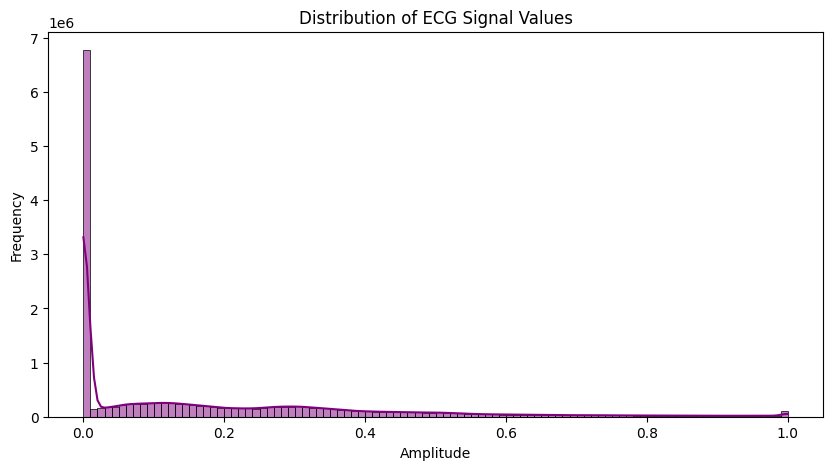

In [10]:
plt.figure(figsize=(10, 5))
sns.histplot(train_df.iloc[:, :-1].values.flatten(), bins=100, kde=True, color='purple')
plt.title("Distribution of ECG Signal Values")
plt.xlabel("Amplitude")
plt.ylabel("Frequency")
plt.show()

### **📈1: Plot Time Steps in Batches**
This approach divides the time steps into smaller, more manageable batches and creates separate box plots for each batch.

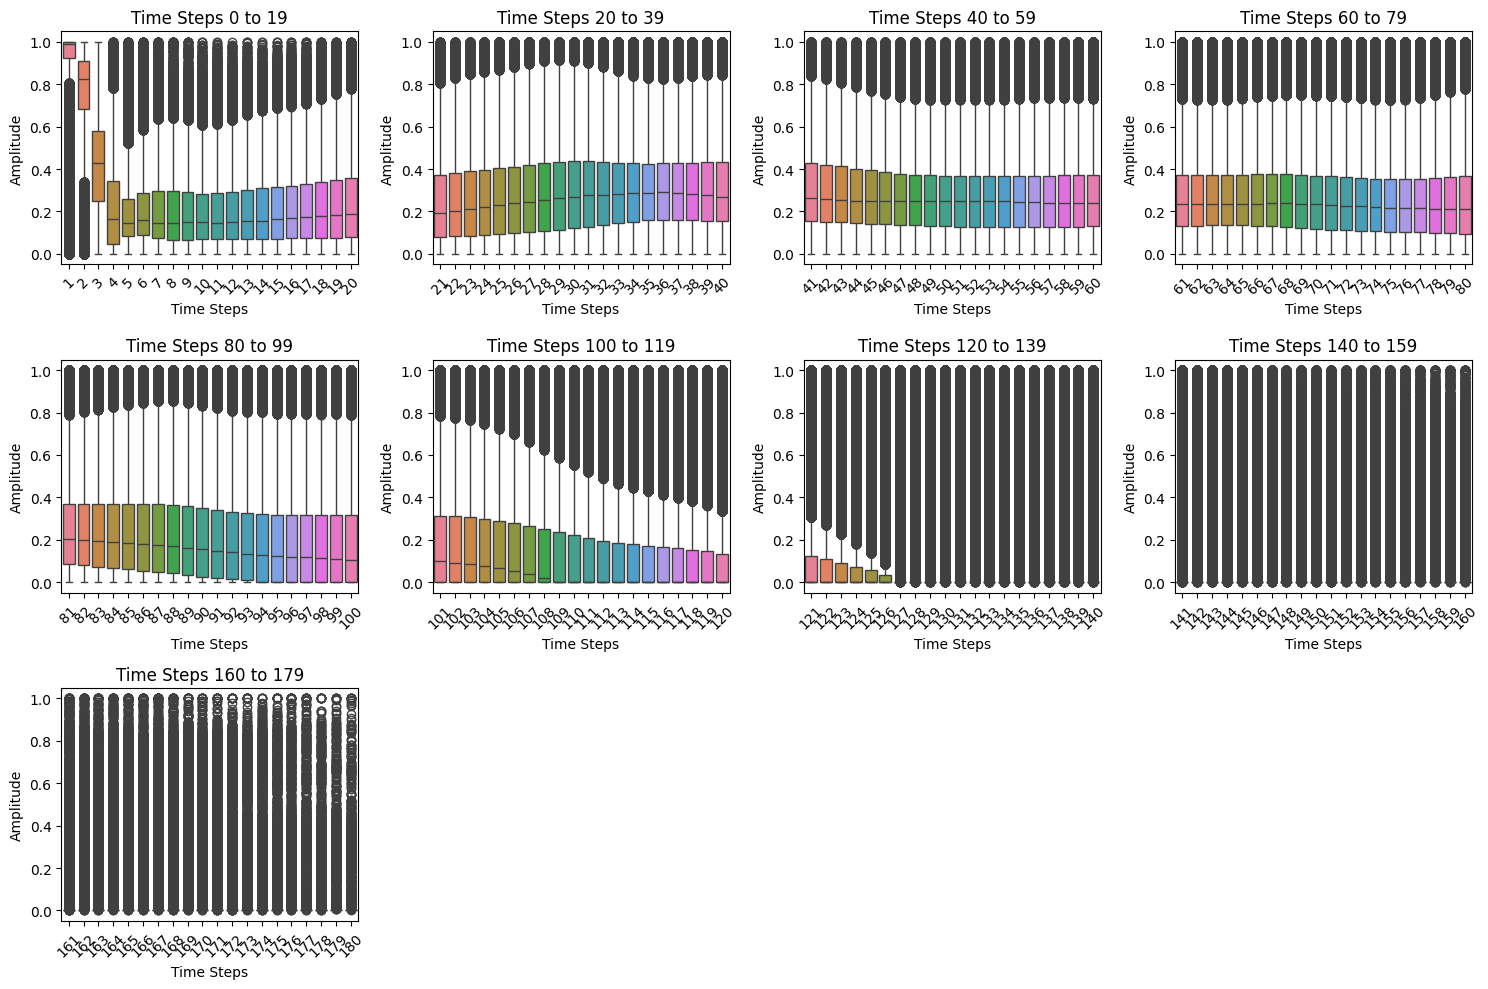

In [11]:
# Number of time steps per batch
batch_size = 20

# Calculate the number of batches
num_batches = train_df.shape[1] // batch_size

# Plot box plots for each batch of time steps
plt.figure(figsize=(15, 10))
for i in range(num_batches):
    start_col = i * batch_size
    end_col = (i + 1) * batch_size
    plt.subplot(3, 4, i + 1)  # Create a grid of subplots (3 rows, 4 columns)
    sns.boxplot(data=train_df.iloc[:, start_col:end_col])
    plt.title(f"Time Steps {start_col} to {end_col - 1}")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability

plt.tight_layout()
plt.show()

**Explanation:**

- **Batch Size:** Each batch contains 20 time steps.
    
- **Subplots:** We create a grid of subplots (3 rows and 4 columns) to display multiple batches.
    
- **Rotation:** x-axis labels are rotated by 45 degrees for better readability.
    
- **Tight Layout:** Ensures subplots do not overlap.

## **6. Detecting Imbalances**

### **6.1 Class Imbalance Visualization**

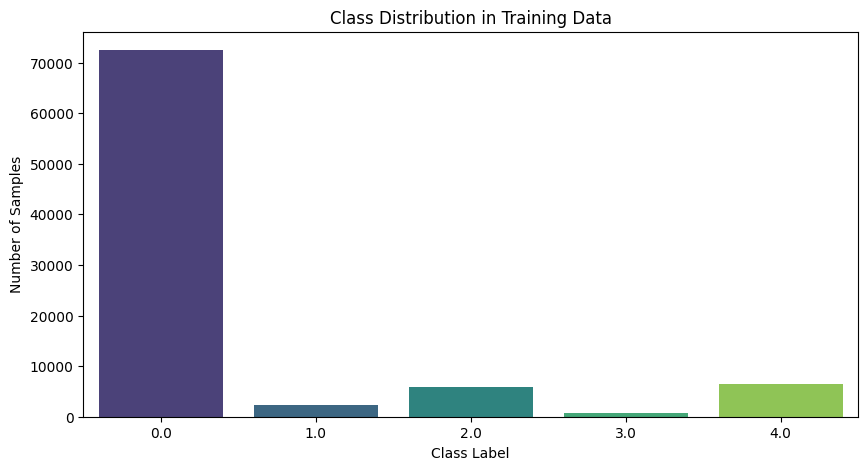

In [13]:
plt.figure(figsize=(10, 5))
sns.countplot(x=train_labels, palette='viridis')
plt.title("Class Distribution in Training Data")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.show()

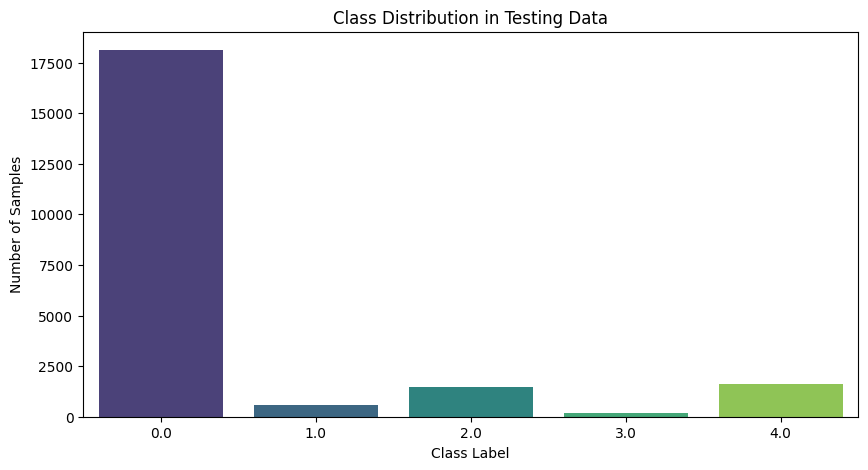

In [14]:
plt.figure(figsize=(10, 5))
sns.countplot(x=test_labels, palette='viridis')
plt.title("Class Distribution in Testing Data")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.show()

### **7.2 Correlation Heatmap**
Given that the dataset contains **187 time steps**, plotting a heatmap for the full correlation matrix can make the axes cluttered and unreadable. To solve this issue, we'll use the following strategies:

1. **Subsampling:** Instead of showing correlations for all 187 time steps, we'll select every **10th time step** to reduce the number of columns and rows.
    
2. **Annotate the Heatmap:** Add annotations to make it easier to interpret the correlations.
    
3. **Adjust Figure Size:** Increase the figure size for better visualization.
    
4. **Color Scaling:** Use a color scale that clearly differentiates positive and negative correlations.

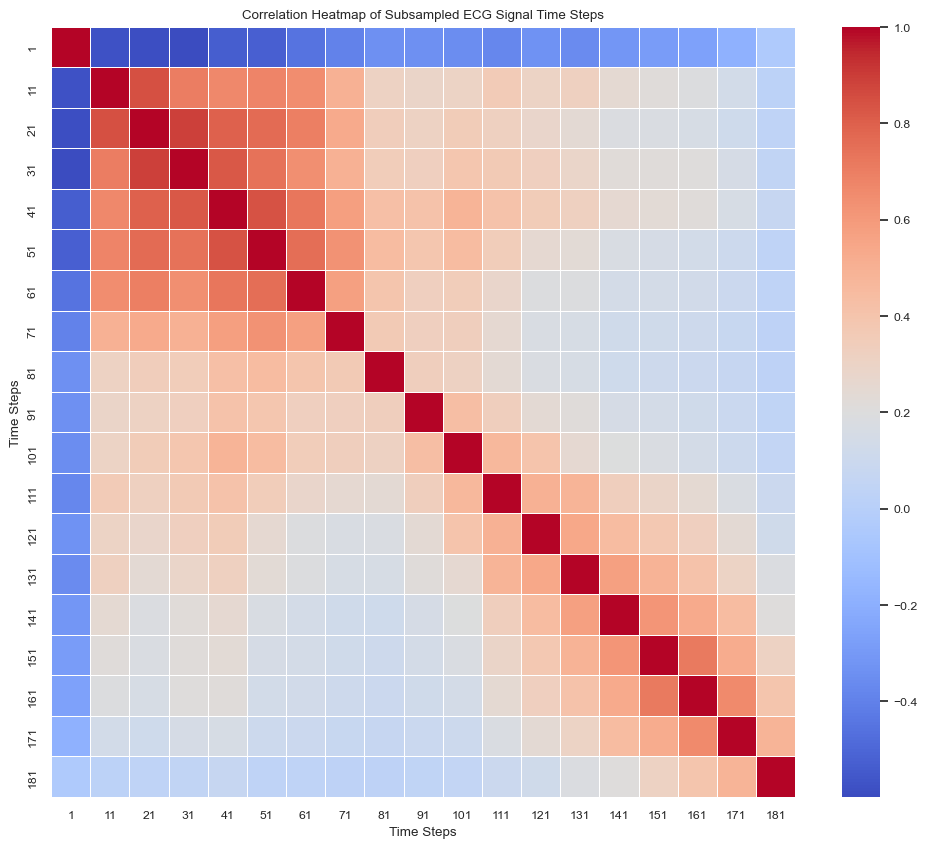

In [16]:
# Extract ECG signal data (excluding the label column)
ecg_data = train_df.iloc[:, :-1]

# Subsample: Select every 10th time step to reduce clutter
subsampled_data = ecg_data.iloc[:, ::10]

# Compute the correlation matrix for the subsampled data
correlation_matrix = subsampled_data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.set(font_scale=0.8)
heatmap = sns.heatmap(
    correlation_matrix,
    annot=False,             # Set to True for annotations if needed
    cmap='coolwarm',         
    linewidths=0.5,          
    xticklabels=subsampled_data.columns,  
    yticklabels=subsampled_data.columns
)

# Add titles and labels
plt.title("Correlation Heatmap of Subsampled ECG Signal Time Steps")
plt.xlabel("Time Steps")
plt.ylabel("Time Steps")

# Display the plot
plt.show()

## **8. Summary of Dataset Insights**
1. **No Missing Values:** The dataset is clean and ready for analysis.

2. **Class Imbalance:** Some classes (e.g., Normal Beats) have significantly more samples than others (e.g., Fusion Beats).

3. **Distinct ECG Patterns:** Each class has unique characteristics (e.g., QRS width).

4. **Signal Range:** The amplitude of ECG signals varies between approximately **-1 and 1**.

## **9. Data Preprocessing**
Normalize data and handle class imbalance.

### **9.1 Normalize data using MinMaxScaler**

In [17]:
# 1. Normalize data using MinMaxScaler
# train_df.columns = train_df.columns.astype(str)
X = train_df.drop('Label', axis=1)  # Drop the target column
y = train_df['Label']  # The target column

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Normalize only the features, not the target

In [18]:
# Check the first 5 rows
print(train_df.head())

          1         2         3         4         5         6         7  \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4  0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   

          8         9        10  ...  179  180  181  182  183  184  185  186  \
0  0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.089202  0.117371  0.150235  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   187  Label  
0  0.0    0.0  
1  0.0    0.0  
2  0.0    0.0  
3  0

In [19]:
# Check statistics (min, max, mean, etc.)
print(train_df.describe())

                  1             2             3             4             5  \
count  87554.000000  87554.000000  87554.000000  87554.000000  87554.000000   
mean       0.890360      0.758160      0.423972      0.219104      0.201127   
std        0.240909      0.221813      0.227305      0.206878      0.177058   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.921922      0.682486      0.250969      0.048458      0.082329   
50%        0.991342      0.826013      0.429472      0.166000      0.147878   
75%        1.000000      0.910506      0.578767      0.341727      0.258993   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                  6             7             8             9            10  \
count  87554.000000  87554.000000  87554.000000  87554.000000  87554.000000   
mean       0.210399      0.205808      0.201773      0.198691      0.196757   
std        0.171909      0.178481      0.177240    

In [20]:
# Check unique values per column
print(train_df.nunique())

1        23408
2        42845
3        49611
4        41007
5        39328
         ...  
184        920
185        843
186        778
187        748
Label        5
Length: 188, dtype: int64


### **9.2 Handling Class Imbalance in the ECG Dataset**
Class imbalance is a common issue in datasets where some classes (categories) have significantly **fewer samples** compared to others. In the context of the **ECG Heartbeat Categorization Dataset**, this imbalance can cause our machine learning or deep learning model to perform poorly, especially on the minority classes. For example, if **"Normal Beats"** vastly outnumber **"Fusion Beats"**, the model might be biased towards predicting "Normal Beats" more frequently.

### **9.2 Handle class imbalance using SMOTE**

In [21]:
# 2. Applying SMOTE to balance the classes in the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)  # 'auto' resamples the minority class
X_res, y_res = smote.fit_resample(X_scaled, y)  # Apply SMOTE on the scaled features

In [22]:
# Check the distribution of classes after applying SMOTE
from collections import Counter

print(f"Class distribution after SMOTE: {Counter(y_res)}")
print(f"Class distribution after SMOTE:\n{pd.Series(y_res).value_counts()}")

Class distribution after SMOTE: Counter({0.0: 72471, 1.0: 72471, 2.0: 72471, 3.0: 72471, 4.0: 72471})
Class distribution after SMOTE:
Label
0.0    72471
1.0    72471
2.0    72471
3.0    72471
4.0    72471
Name: count, dtype: int64


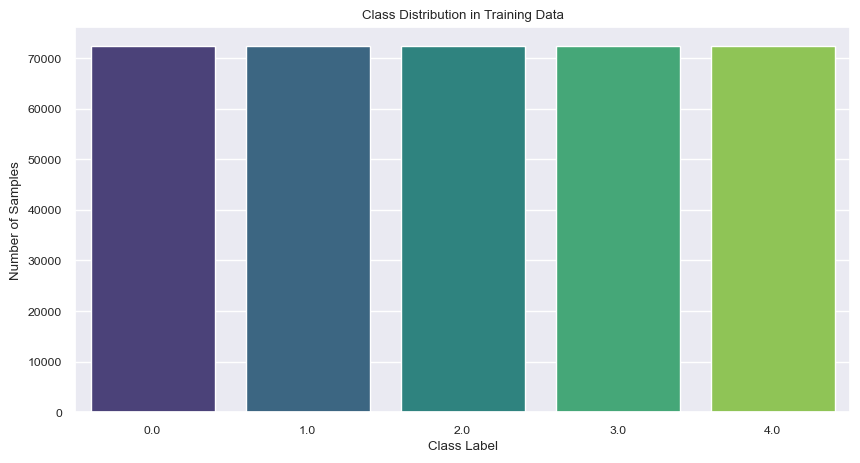

In [23]:
plt.figure(figsize=(10, 5))
sns.countplot(x=y_res, palette='viridis')
plt.title("Class Distribution in Training Data")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.show()

## **10. Model Training and Evaluation** 

In [24]:
# Reshape the data to match the input shape of the model (e.g., (num_samples, 187, 1))
from tensorflow.keras.utils import to_categorical
X_res_reshaped = X_res.reshape((X_res.shape[0], 187, 1))

# One-hot encode the labels
y_res_encoded = to_categorical(y_res, num_classes=5)  # Assuming 5 classes

In [25]:
# Assuming the last column is the label (target) and the others are features
X_test = test_df.iloc[:, :-1].values  # Features 
y_test = test_df.iloc[:, -1].values  # Labels 

In [26]:
# Normalize the test data using MinMaxScaler (assuming the training data was scaled)
scaler = MinMaxScaler()
X_test_scaled = scaler.fit_transform(X_test)  # Apply the same scaler that was used for training data

In [27]:
# Reshape the test data to match the model's expected input shape (e.g., (num_samples, 187, 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 187, 1))

In [28]:
# One-hot encode the labels for evaluation (if needed, based on model output)
y_test_encoded = to_categorical(y_test, num_classes=5)  # Assuming 5 classes

### **1. 1D Convolutional Neural Networks (1D CNNs)**
1D CNNs are designed to process sequential data like ECG signals by
applying filters to detect local patterns (e.g., P-wave, QRS complex,
T-wave).

In [29]:
# Define and compile the model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(187, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')  # 5 classes: N, S, V, F, Q
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 185, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 92, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 90, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 45, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 2880)              0         
                                                                 
 dense (Dense)               (None, 64)                1

In [30]:
# Train the model 
history = model.fit(X_res_reshaped, y_res_encoded, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
9059/9059 [==============================] - 59s 6ms/step - loss: 0.1888 - accuracy: 0.9323 - val_loss: 0.2695 - val_accuracy: 0.9218
Epoch 2/10
9059/9059 [==============================] - 54s 6ms/step - loss: 0.0668 - accuracy: 0.9776 - val_loss: 0.1008 - val_accuracy: 0.9652
Epoch 3/10
9059/9059 [==============================] - 54s 6ms/step - loss: 0.0436 - accuracy: 0.9859 - val_loss: 0.0480 - val_accuracy: 0.9859
Epoch 4/10
9059/9059 [==============================] - 54s 6ms/step - loss: 0.0315 - accuracy: 0.9901 - val_loss: 0.0584 - val_accuracy: 0.9828
Epoch 5/10
9059/9059 [==============================] - 53s 6ms/step - loss: 0.0240 - accuracy: 0.9924 - val_loss: 0.0346 - val_accuracy: 0.9895
Epoch 6/10
9059/9059 [==============================] - 53s 6ms/step - loss: 0.0196 - accuracy: 0.9939 - val_loss: 0.0173 - val_accuracy: 0.9950
Epoch 7/10
9059/9059 [==============================] - 55s 6ms/step - loss: 0.0158 - accuracy: 0.9951 - val_loss: 0.0155 - val_ac

In [31]:
# Predicting labels for the test set using the trained model
y_pred = model.predict(X_test_reshaped)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Compute test accuracy
test_accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Test Accuracy: {test_accuracy:.4f}")

685/685 [==============================] - 3s 5ms/step
Test Accuracy: 0.9798


In [32]:
# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_true_classes, y_pred_classes, average='macro') 
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_true_classes, y_pred_classes, average='macro') 
print(f"Recall: {recall:.4f}")

# F1-Score
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9798
Precision: 0.9031
Recall: 0.9086
F1-Score: 0.9057


In [33]:
# Predict
y_pred_probs = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded y_test to labels
y_true = np.argmax(y_test_encoded, axis=1)

# Classification Report
print(classification_report(y_true, y_pred, target_names=[
    "Normal (N)", "Supraventricular (S)", "Ventricular (V)", "Fusion (F)", "Unknown (Q)"
]))

685/685 [==============================] - 3s 5ms/step
                      precision    recall  f1-score   support

          Normal (N)       0.99      0.99      0.99     18118
Supraventricular (S)       0.78      0.80      0.79       556
     Ventricular (V)       0.96      0.94      0.95      1448
          Fusion (F)       0.80      0.84      0.82       162
         Unknown (Q)       0.99      0.98      0.99      1608

            accuracy                           0.98     21892
           macro avg       0.90      0.91      0.91     21892
        weighted avg       0.98      0.98      0.98     21892



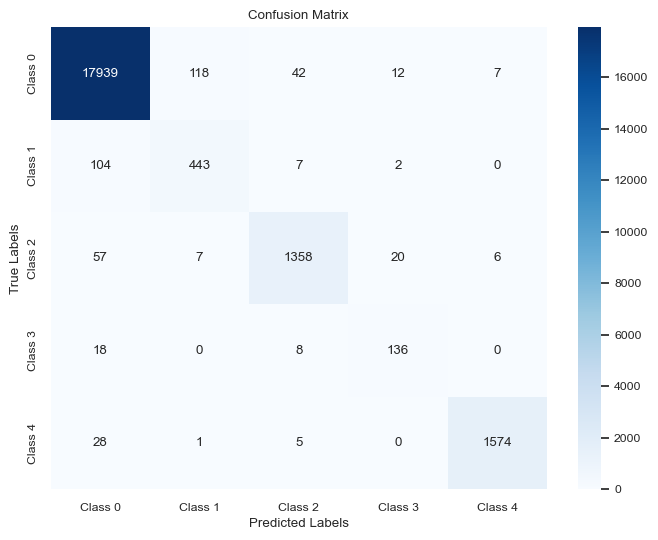

In [34]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

ROC-AUC Score: 0.9858


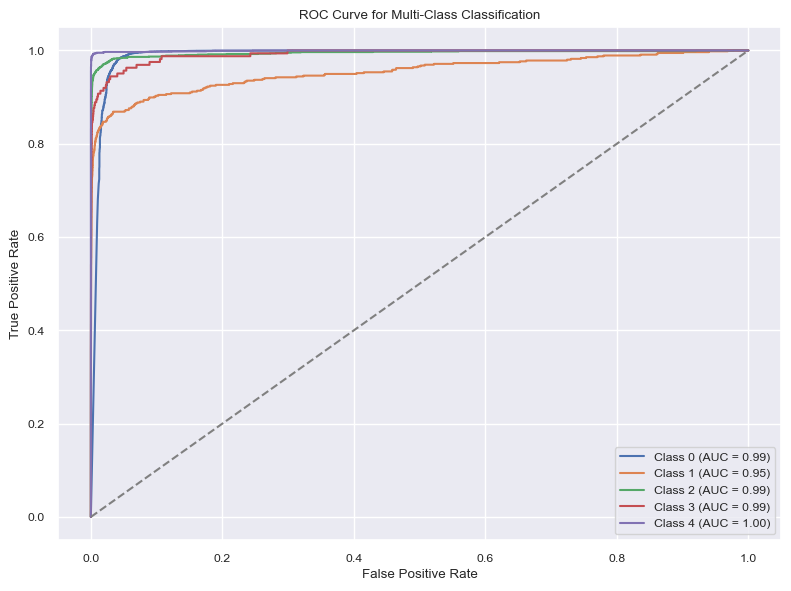

In [35]:
# One-hot encode ground truth
y_test_binary = label_binarize(y_true, classes=[0, 1, 2, 3, 4])  

# ROC-AUC Score (macro average)
roc_auc = roc_auc_score(y_test_binary, y_pred_probs, average='macro', multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC curve per class
plt.figure(figsize=(8,6))
for i in range(5):  # 5 classes
    fpr, tpr, _ = roc_curve(y_test_binary[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve for Multi-Class Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

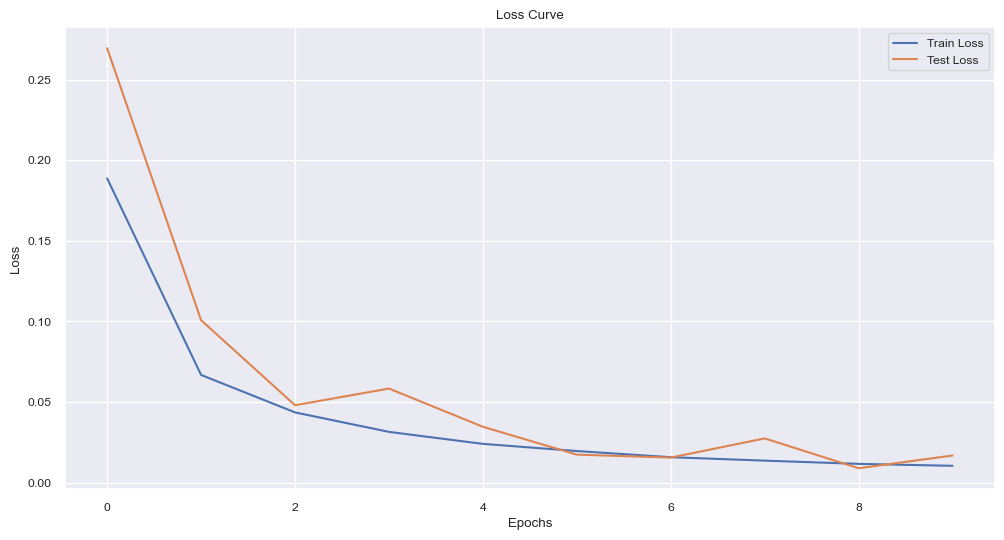

In [39]:
# Plotting the loss curve
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')  # Training loss
plt.plot(history.history['val_loss'], label='Test Loss')  # Validation loss
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

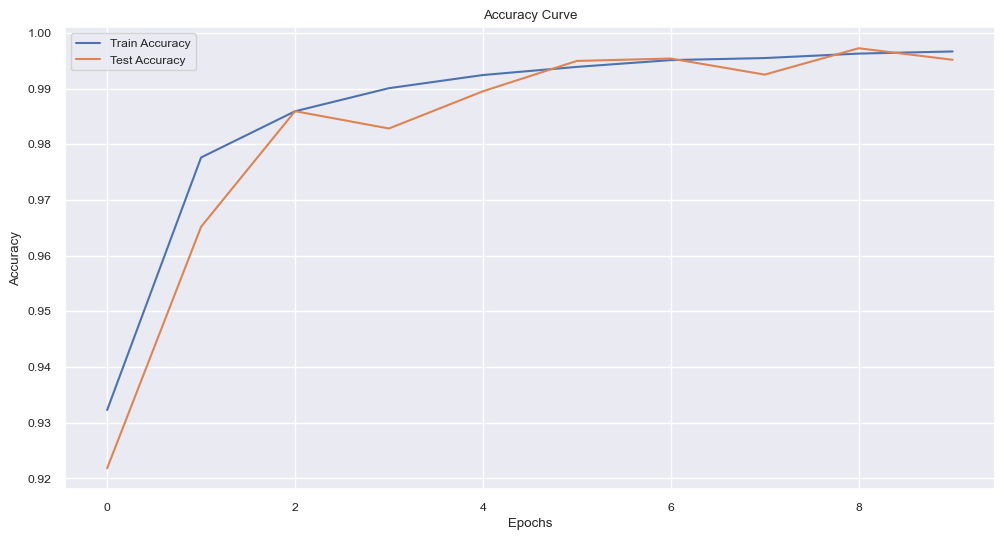

In [40]:
# Plotting the accuracy curve
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [42]:
model.save("CNN_model.h5", save_format="h5")